table of contents
1. 準備
2. データのインポート
3. 得点/失点
4. シュート/被シュート
5. ボール保持/非保持

# 準備

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

In [35]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

twitter_color = '#841d26'

# データのインポート

In [2]:
base_dir = os.path.join('..','..')
data_dir = os.path.join(base_dir, 'data', 'raw')

def read_dfs():
    players_df = pd.read_json(os.path.join(data_dir, 'players.json'))
    teams_df = pd.read_json(os.path.join(data_dir, 'teams.json'))

    # encode, decode
    players_df['shortName'] = players_df.shortName.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    teams_df['name'] = teams_df.name.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    return players_df, teams_df

players_df, teams_df = read_dfs()

competition_list = [infile.replace('matches_','').replace('.json','') for infile in os.listdir(os.path.join(data_dir, 'matches')) if infile.endswith('.json')]

print(competition_list)

['World_Cup', 'Italy', 'Germany', 'England', 'France', 'Spain', 'European_Championship']


In [3]:
selected_competition = 'Spain'

def read_events_df(selected_competition):
    events_df = pd.read_json(os.path.join(data_dir, 'events', f'events_{selected_competition}.json'))
    return events_df

def read_matches_df(selected_competition):
    matches_df = pd.read_json(os.path.join(data_dir, 'matches', f'matches_{selected_competition}.json'))
    matches_df['date_time'] = pd.to_datetime(matches_df.dateutc)

    # encode, decode
    matches_df['label'] = matches_df.label.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))
    matches_df['venue'] = matches_df.venue.apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

    # concate label, venue, date_time
    matches_df['name'] = matches_df[['label', 'venue', 'date_time']].apply(lambda xs: f'{xs[0]} @{xs[1]}, {xs[2].date()}', axis=1)

    return matches_df.sort_values('date_time')

matches_df = read_matches_df(selected_competition)

name_list = matches_df.name.tolist()

In [36]:
# selected_match = 'Germany - France, 0 - 2 @Stade Vélodrome, 2016-07-07'
# selected_wyId = matches_df[matches_df.name == selected_match].wyId.values[0]

events_df = read_events_df(selected_competition)

matchPeriod_list = ['1H', '2H']

# df_tmp = events_df[(events_df.matchId == selected_wyId)&(events_df.eventName=='Shot')&(events_df.matchPeriod.isin(matchPeriod_list))]

# 得点 / 失点

In [37]:
minute = 15; end = 45+minute+1
goal_time_summary = events_df[events_df.eventName.isin(['Shot', 'Free Kick'])].groupby(['teamId', 'matchPeriod', pd.cut(events_df[events_df.eventName.isin(['Shot', 'Free Kick'])].eventSec/60, np.arange(-1, end, minute))]).tags.agg(lambda xs: np.sum([[(101 in [tag_dict['id'] for tag_dict in tags])or(102 in [tag_dict['id'] for tag_dict in tags])] for tags in xs])).reset_index() 

name_dict = {inter:f'{inter.left+1}~{inter.right}' if (inter.left!=-1)and(inter.right!=end-2) else f'~{inter.right}' if inter.left==-1 else f'{inter.left+1}~' for inter in goal_time_summary.eventSec.unique().tolist()}

goal_time_summary['name'] = goal_time_summary.eventSec.apply(lambda x: name_dict[x])

goal_time_summary = goal_time_summary.rename(columns={'tags':'Number of Goals'})

In [38]:
goal_time_summary

,teamId,matchPeriod,eventSec,Number of Goals,name
0,674,1H,"(-1, 14]",3,~14
1,674,1H,"(14, 29]",12,15~29
2,674,1H,"(29, 44]",8,30~44
3,674,1H,"(44, 59]",1,45~
4,674,2H,"(-1, 14]",8,~14
...,...,...,...,...,...
155,756,1H,"(44, 59]",3,45~
156,756,2H,"(-1, 14]",9,~14
157,756,2H,"(14, 29]",9,15~29
158,756,2H,"(29, 44]",7,30~44


In [22]:
goal_time_summary.groupby('teamId')['Number of Goals'].sum()

teamId
674    63
675    91
676    96
677    38
678    39
679    57
680    48
682    56
683    23
684    56
687    64
691    33
692    58
695    42
696    40
698    41
701    43
712    32
714    24
756    50
Name: Number of Goals, dtype: int64

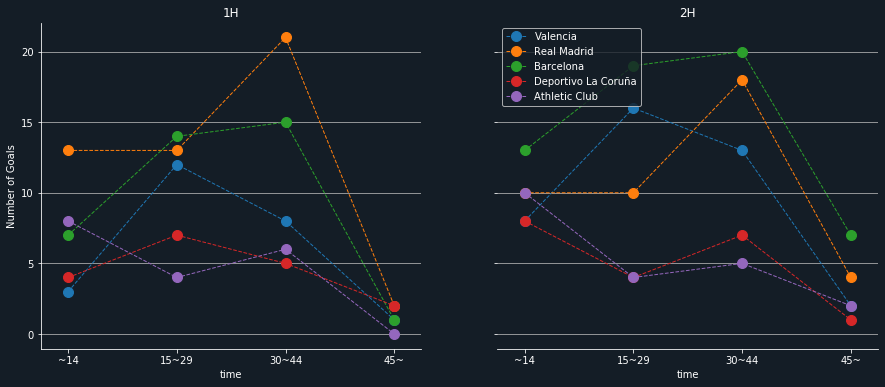

In [46]:
matchPeriod_list = ['1H', '2H']
teamId_list = goal_time_summary.teamId.unique().tolist()[:5]
c_name = 'Number of Goals'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True, facecolor=twitter_color)
for i, matchPeriod in enumerate(matchPeriod_list):
    ax = axes[i]
    for teamId in teamId_list:
        team_name = teams_df[teams_df.wyId==teamId].name.values[0]
#         shot_time_summary[(shot_time_summary.teamId==teamId)&(shot_time_summary.matchPeriod==matchPeriod)].plot(x='name', y=c_name, kind='bar', label=team_name, rot=0, ax=ax)
        goal_time_summary[(goal_time_summary.teamId==teamId)&(goal_time_summary.matchPeriod==matchPeriod)].plot(x='name', y=c_name, label=team_name, marker='o', markersize=10, linestyle='dashed', linewidth=1, ax=ax, legend=i==1)
    
    ax.set_xticks(range(len(name_dict))); ax.set_xticklabels(list(name_dict.values()))
    ax.set_xlim([-0.25, len(name_dict)-1+0.25])
    ax.set_ylabel(c_name); ax.set_xlabel('time'); ax.set_title(matchPeriod)
    ax.patch.set_facecolor('#141d26')
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    ax.grid(axis='y')
    if i == 1:
        ax.legend(facecolor='#141d26');
        ax.spines['left'].set_visible(False)
        
    ax.patch.set_facecolor('#141d26')
    
fig.patch.set_facecolor('#141d26')

## おまけ（各国リーグの比較）

Text(0.5, 0.98, '17/18 European League Data via WyScout')

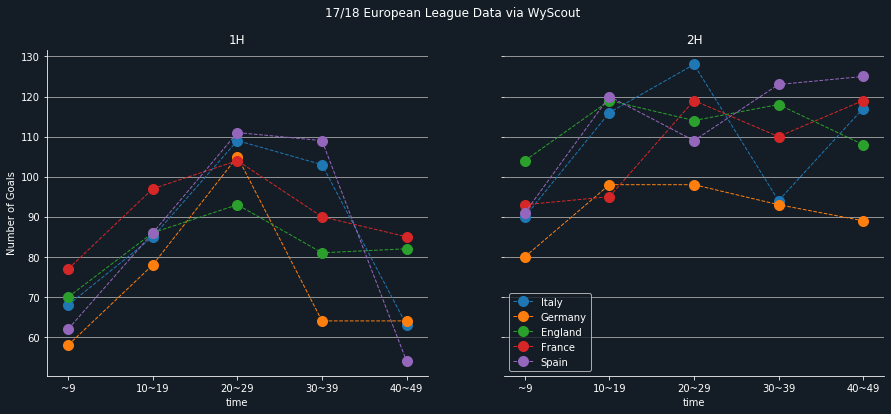

In [50]:
matchPeriod_list = ['1H', '2H']
c_name = 'Number of Goals'
minute = 10; end = 45+minute+1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True)

for competition in competition_list[1:-1]:
    events_df = read_events_df(competition)
    goal_time_summary = events_df[events_df.eventName.isin(['Shot', 'Free Kick'])].groupby(['matchPeriod', pd.cut(events_df[events_df.eventName.isin(['Shot', 'Free Kick'])].eventSec/60, np.arange(-1, end, minute))]).tags.agg(lambda xs: np.sum([[(101 in [tag_dict['id'] for tag_dict in tags])or(102 in [tag_dict['id'] for tag_dict in tags])] for tags in xs])).reset_index() 
    name_dict = {inter:f'{inter.left+1}~{inter.right}' if (inter.left!=-1)and(inter.right!=end-2) else f'~{inter.right}' if inter.left==-1 else f'{inter.left+1}~' for inter in goal_time_summary.eventSec.unique().tolist()}
    goal_time_summary['name'] = goal_time_summary.eventSec.apply(lambda x: name_dict[x])
    goal_time_summary = goal_time_summary.rename(columns={'tags':c_name})
    
    for i, matchPeriod in enumerate(matchPeriod_list):
        ax = axes[i]
        goal_time_summary[goal_time_summary.matchPeriod==matchPeriod].plot(x='name', y=c_name, label=competition, marker='o', markersize=10, linestyle='dashed', linewidth=1, ax=ax, legend=i==1)

for i, ax in enumerate(axes):
    ax.set_xticks(range(len(name_dict))); ax.set_xticklabels(list(name_dict.values()))
    ax.set_xlim([-0.25, len(name_dict)-1+0.25])
    ax.set_ylabel(c_name); ax.set_xlabel('time'); ax.set_title(matchPeriod_list[i])
    ax.patch.set_facecolor('#141d26')
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    ax.grid(axis='y')
    
    if i == 1:
        ax.legend(facecolor='#141d26');
        ax.spines['left'].set_visible(False)

fig.patch.set_facecolor('#141d26')

fig.suptitle('17/18 European League Data via WyScout')

# シュート / 被シュート

In [7]:
events_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422


In [111]:
minute = 15; end = 45+minute+1

shot_time_summary = events_df[events_df.eventName=='Shot'].groupby(['teamId', 'matchPeriod', pd.cut(events_df[events_df.eventName=='Shot'].eventSec/60, np.arange(0, end, minute))]).size().reset_index()

name_dict = {inter:f'{inter.left}~{inter.right}' if (inter.left!=0)and(inter.right!=end-1) else f'~{inter.right}' if inter.left==0 else f'{inter.left}~' for inter in shot_time_summary.eventSec.unique().tolist()}

shot_time_summary['name'] = shot_time_summary.eventSec.apply(lambda x: name_dict[x])

shot_time_summary = shot_time_summary.rename(columns={0:'Number of Shots'})

In [112]:
shot_time_summary

,teamId,matchPeriod,eventSec,Number of Shots,name
0,674,1H,"(0, 15]",49,~15
1,674,1H,"(15, 30]",76,15~30
2,674,1H,"(30, 45]",70,30~45
3,674,1H,"(45, 60]",3,45~
4,674,2H,"(0, 15]",76,~15
...,...,...,...,...,...
155,756,1H,"(45, 60]",6,45~
156,756,2H,"(0, 15]",64,~15
157,756,2H,"(15, 30]",64,15~30
158,756,2H,"(30, 45]",63,30~45


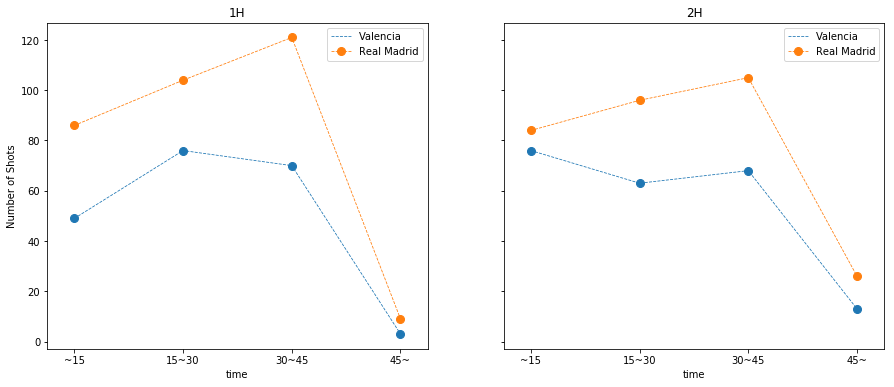

In [113]:
matchPeriod_list = ['1H', '2H']
teamId_list = shot_time_summary.teamId.unique().tolist()[:2]
c_name = 'Number of Shots'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True)
for i, matchPeriod in enumerate(matchPeriod_list):
    ax = axes[i]
    for teamId in teamId_list:
        team_name = teams_df[teams_df.wyId==teamId].name.values[0]
#         shot_time_summary[(shot_time_summary.teamId==teamId)&(shot_time_summary.matchPeriod==matchPeriod)].plot(x='name', y=c_name, kind='bar', label=team_name, rot=0, ax=ax)
        shot_time_summary[(shot_time_summary.teamId==teamId)&(shot_time_summary.matchPeriod==matchPeriod)].plot(x='name', y=c_name, label=team_name, marker='o', markersize=8, linestyle='dashed', linewidth=0.8, ax=ax)
    ax.set_xticks(range(len(name_dict)))
    ax.set_xticklabels(list(name_dict.values()))
    ax.set_xlim([-0.25, len(name_dict)-1+0.25])
    ax.set_ylabel(c_name); ax.set_xlabel('time'); ax.set_title(matchPeriod)

# ボール保持 / 非保持

In [114]:

events_df.head(100)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
...,...,...,...,...,...,...,...,...,...,...,...,...
95,8,Simple pass,[{'id': 1801}],3496,"[{'y': 58, 'x': 56}, {'y': 94, 'x': 80}]",2565548,Pass,695,1H,395.158787,85,180864643
96,8,Cross,"[{'id': 402}, {'id': 801}, {'id': 1801}]",3919,"[{'y': 94, 'x': 80}, {'y': 5, 'x': 97}]",2565548,Pass,695,1H,398.739145,80,180864645
97,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",225089,"[{'y': 5, 'x': 97}, {'y': 14, 'x': 89}]",2565548,Duel,695,1H,406.973531,11,180864647
98,1,Ground defending duel,"[{'id': 502}, {'id': 701}, {'id': 1802}]",15214,"[{'y': 95, 'x': 3}, {'y': 86, 'x': 11}]",2565548,Duel,682,1H,407.549521,12,180864479
